In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
path_ = "C:/Users/corsair/.keras/datasets/kagglecatsanddogs_3367a/PetImages"

In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(path_, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


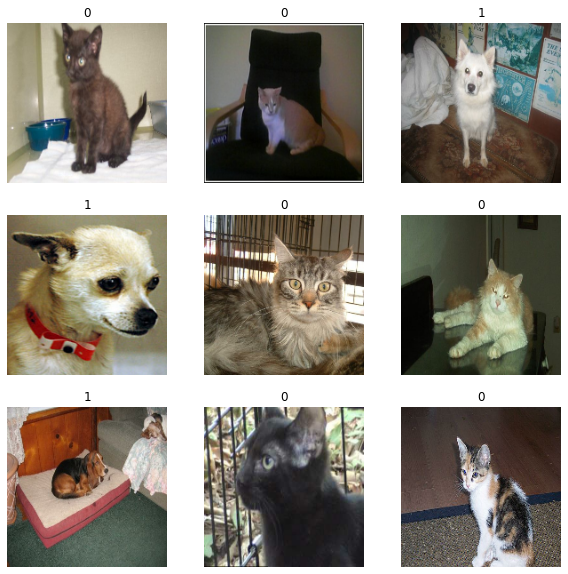

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


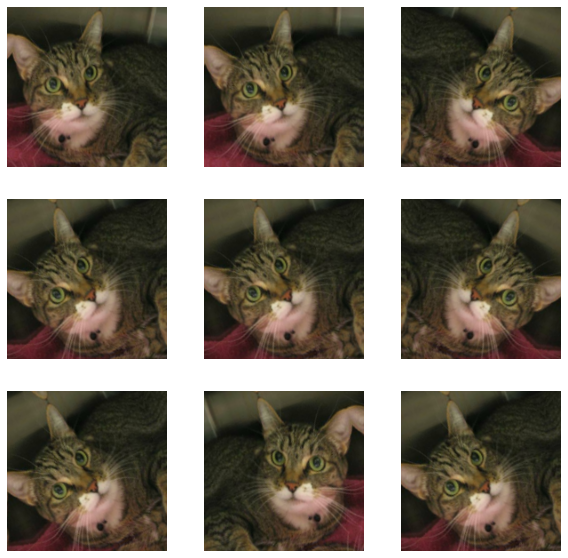

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    print(type(inputs))
    # Image augmentation block
    x = data_augmentation(inputs)
    print(type(x))
    
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
#epochs = 50
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
586/586 [==============================] - 149s 245ms/step - loss: 0.6654 - accuracy: 0.6359 - val_loss: 0.6537 - val_accuracy: 0.6386
Epoch 2/20
586/586 [==============================] - 143s 243ms/step - loss: 0.4653 - accuracy: 0.7850 - val_loss: 0.3631 - val_accuracy: 0.8484
Epoch 3/20
586/586 [==============================] - 143s 244ms/step - loss: 0.3674 - accuracy: 0.8356 - val_loss: 0.3651 - val_accuracy: 0.8520
Epoch 4/20
586/586 [==============================] - 143s 243ms/step - loss: 0.3189 - accuracy: 0.8632 - val_loss: 0.2931 - val_accuracy: 0.8698
Epoch 5/20
586/586 [==============================] - 143s 244ms/step - loss: 0.2681 - accuracy: 0.8886 - val_loss: 0.2571 - val_accuracy: 0.8883
Epoch 6/20
586/586 [==============================] - 143s 243ms/step - loss: 0.2308 - accuracy: 0.9016 - val_loss: 0.2531 - val_accuracy: 0.8994
Epoch 7/20
586/586 [==============================] - 143s 243ms/step - loss: 0.2178 - accuracy: 0.9074 - val_loss: 0.3335 -

In [20]:
model.save('trained_model_cats_and_dogs.h5')
model.save('trained_model_cats_and_dogs')

INFO:tensorflow:Assets written to: trained_model_cats_and_dogs\assets


In [16]:
img = keras.preprocessing.image.load_img(path_+
    "/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.70 percent cat and 0.30 percent dog.


In [23]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(x=(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype) ))

print("/" * 50)
print(type(full_model))
print("/" * 50)

# Get frozen ConcreteFunction
# https://github.com/tensorflow/tensorflow/issues/36391#issuecomment-596055100
frozen_func = convert_variables_to_constants_v2(full_model, lower_control_flow=False)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                    logdir="./frozen_models",
                    name="complex_frozen_graph.pb",
                    as_text=False)

# Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("./frozen_models/complex_frozen_graph.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["x:0", "x_1:0", "x_2:0"],
                                outputs=["Identity:0", "Identity_1:0"],
                                print_graph=True)

# Note that we only have "one" input and "output" for the loaded frozen function
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Get predictions
frozen_graph_predictions = frozen_func(x=tf.constant(title_data[0:1]), x_1=tf.constant(body_data[0:1]), x_2=tf.constant(tags_data[0:1]))
frozen_graph_predictions_priority = frozen_graph_predictions[0]
frozen_graph_predictions_department = frozen_graph_predictions[1]

print("-" * 50)
print("Example TensorFlow frozen graph prediction reference:")
print(frozen_graph_predictions_priority.numpy())
print(frozen_graph_predictions_department.numpy())

# The two predictions should be almost the same.
assert np.allclose(a=frozen_graph_predictions_priority.numpy(), b=predictions_priority, rtol=1e-05, atol=1e-08, equal_nan=False)
assert np.allclose(a=frozen_graph_predictions_department.numpy(), b=predictions_department, rtol=1e-05, atol=1e-08, equal_nan=False)


//////////////////////////////////////////////////
<class 'tensorflow.python.eager.function.ConcreteFunction'>
//////////////////////////////////////////////////


InvalidArgumentError: Cannot convert a Tensor of dtype resource to a NumPy array.